https://towardsdatascience.com/step-by-step-guide-building-a-prediction-model-in-python-ac441e8b9e8b

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

2023-05-06 19:07:35.385046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('/Users/mcardonasanchez/Desktop/Online Courses/The-Data-Science-Course-2021-All-Resources/Other/data/aapl_stock_lyr.csv')
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,04/12/2023,$160.10,50133060,$161.22,$162.06,$159.78
1,04/11/2023,$160.80,47644220,$162.35,$162.36,$160.51
2,04/10/2023,$162.03,47716880,$161.42,$162.03,$160.08
3,04/06/2023,$164.66,45390120,$162.43,$164.9584,$162.00
4,04/05/2023,$163.76,51511740,$164.74,$165.05,$161.80


In [3]:
df.tail()

,Date,Close/Last,Volume,Open,High,Low
245,04/20/2022,$167.23,67929810,$168.76,$168.88,$166.10
246,04/19/2022,$167.40,67723830,$165.02,$167.82,$163.91
247,04/18/2022,$165.07,69023940,$163.92,$166.5984,$163.57
248,04/14/2022,$165.29,75329380,$170.62,$171.27,$165.04
249,04/13/2022,$170.40,70618930,$167.39,$171.04,$166.77


In [4]:
df = df[['Date', 'Close/Last']]
df = df.rename(columns={'Close/Last': 'Close'})
df.head()

,Date,Close
0,04/12/2023,$160.10
1,04/11/2023,$160.80
2,04/10/2023,$162.03
3,04/06/2023,$164.66
4,04/05/2023,$163.76


In [5]:
df.dtypes

Date     object
Close    object
dtype: object

In [6]:
df = df.replace({'\$':''}, regex=True)
df = df.astype({'Close': float})
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

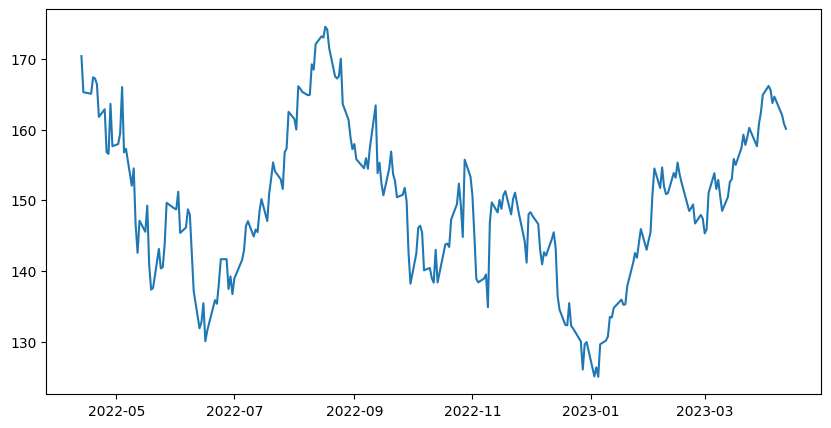

In [7]:
df.index = df['Date']
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(df['Close'], label='Close price history')

In [8]:
df = df.sort_index(ascending=True, axis=0)
data = pd.DataFrame(index=range(0,len(df)), columns=['Date', 'Close'])

for i in range(0,len(data)):
    data['Date'][i] = df['Date'][i]
    data['Close'][i] = df['Close'][i]
data.head()

,Date,Close
0,2022-04-13 00:00:00,170.4
1,2022-04-14 00:00:00,165.29
2,2022-04-18 00:00:00,165.07
3,2022-04-19 00:00:00,167.4
4,2022-04-20 00:00:00,167.23


In [9]:
data = df
data.head()

,Date,Close
Date,,
2022-04-13,2022-04-13,170.40
2022-04-14,2022-04-14,165.29
2022-04-18,2022-04-18,165.07
2022-04-19,2022-04-19,167.40
2022-04-20,2022-04-20,167.23


Min-Max Scaler

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))

data.index = data.Date
data.drop('Date', axis=1, inplace=True)

final_data = data.values

train_data = final_data[0:200,:] # 200
valid_data = final_data[200:,:] # 50

scaler = MinMaxScaler(feature_range=(0,1))

scaled_data = scaler.fit_transform(final_data)
x_train_data, y_train_data = [], []
for i in range(60, len(train_data)):
    # take 60 previous observations as x
    x_train_data.append(scaled_data[i-60:i, 0])
    # take last observation in the 60 window as y
    y_train_data.append(scaled_data[i,0])


In [11]:
x_train_data = np.array(x_train_data)
y_train_data = np.array(y_train_data)

In [12]:
x_train_data.shape

(140, 60)

LSTM Model

LSTM models work great when making predictions based on time-series datasets.\
Units: dimensionality of output space\
Return_sequences: whether to return the last output in the output sequence, or the full sequence\

In [17]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=50, input_shape=(np.shape(x_train_data)[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

model_data = data[len(data)-len(valid_data)-60:].values # 250 - 50 - 60 -> 140:250
model_data = model_data.reshape(-1,1)
model_data = scaler.transform(model_data)

2023-05-01 09:11:51.653823: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
model_data.shape

(110, 1)

Train and Test Data

In [31]:
# adam: stochastic gradient descent method
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=20,batch_size=1,verbose=2)

X_test = []
for i in range(60, model_data.shape[0]):
    X_test.append(model_data[i-60:i,0]) # for the last 50 values, get their 60 previous window
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

Epoch 1/20
140/140 - 5s - loss: 0.0083 - 5s/epoch - 36ms/step
Epoch 2/20
140/140 - 2s - loss: 0.0069 - 2s/epoch - 16ms/step
Epoch 3/20
140/140 - 2s - loss: 0.0067 - 2s/epoch - 15ms/step
Epoch 4/20
140/140 - 2s - loss: 0.0072 - 2s/epoch - 15ms/step
Epoch 5/20
140/140 - 2s - loss: 0.0062 - 2s/epoch - 15ms/step
Epoch 6/20
140/140 - 2s - loss: 0.0054 - 2s/epoch - 18ms/step
Epoch 7/20
140/140 - 2s - loss: 0.0064 - 2s/epoch - 15ms/step
Epoch 8/20
140/140 - 2s - loss: 0.0051 - 2s/epoch - 15ms/step
Epoch 9/20
140/140 - 2s - loss: 0.0050 - 2s/epoch - 15ms/step
Epoch 10/20
140/140 - 2s - loss: 0.0050 - 2s/epoch - 15ms/step
Epoch 11/20
140/140 - 2s - loss: 0.0048 - 2s/epoch - 15ms/step
Epoch 12/20
140/140 - 2s - loss: 0.0054 - 2s/epoch - 15ms/step
Epoch 13/20
140/140 - 2s - loss: 0.0048 - 2s/epoch - 15ms/step
Epoch 14/20
140/140 - 2s - loss: 0.0051 - 2s/epoch - 15ms/step
Epoch 15/20
140/140 - 2s - loss: 0.0060 - 2s/epoch - 15ms/step
Epoch 16/20
140/140 - 2s - loss: 0.0055 - 2s/epoch - 16ms/step
E

Prediction Function

In [32]:
X_test.shape

(50, 60, 1)

In [33]:
predicted_stock_price = lstm_model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

2/2 [==============================] - 1s 9ms/step


/var/folders/vt/10z3pk5n06vgby_lx927m_6w0000gp/T/ipykernel_58487/573915457.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = predicted_stock_price


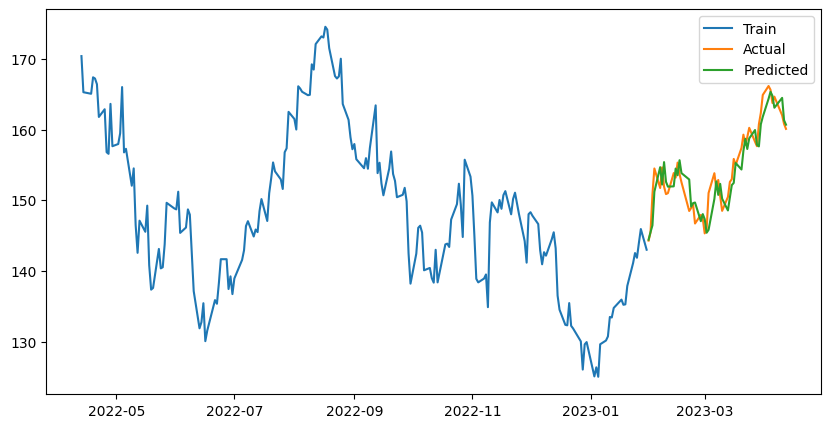

In [34]:
train_data = data[:200]
valid_data = data[200:]
valid_data['Predictions'] = predicted_stock_price
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(train_data['Close'])
plt.plot(valid_data[['Close', 'Predictions']])
plt.legend(['Train','Actual', 'Predicted'])

In [35]:
df

,Close,Tomorrow
Date,,
2022-04-13,170.40,NaN
2022-04-14,165.29,170.40
2022-04-18,165.07,165.29
2022-04-19,167.40,165.07
2022-04-20,167.23,167.40
...,...,...
2023-04-05,163.76,165.63
2023-04-06,164.66,163.76
2023-04-10,162.03,164.66


In [36]:
new_df = df
new_df['Tomorrow'] = new_df['Close'].shift(1)
new_df = new_df.rename(columns={'Close':'Today'})
new_df = new_df.drop(new_df.index[0])
new_df

,Today,Tomorrow
Date,,
2022-04-14,165.29,170.40
2022-04-18,165.07,165.29
2022-04-19,167.40,165.07
2022-04-20,167.23,167.40
2022-04-21,166.42,167.23
...,...,...
2023-04-05,163.76,165.63
2023-04-06,164.66,163.76
2023-04-10,162.03,164.66


In [37]:
new_df['Daily_change'] = np.log(new_df['Tomorrow']/new_df['Today'])
new_df

,Today,Tomorrow,Daily_change
Date,,,
2022-04-14,165.29,170.40,0.030447
2022-04-18,165.07,165.29,0.001332
2022-04-19,167.40,165.07,-0.014017
2022-04-20,167.23,167.40,0.001016
2022-04-21,166.42,167.23,0.004855
...,...,...,...
2023-04-05,163.76,165.63,0.011354
2023-04-06,164.66,163.76,-0.005481
2023-04-10,162.03,164.66,0.016101


(array([ 2.,  0.,  2., 16., 48., 68., 65., 27., 15.,  6.]),
 array([-0.08523649, -0.07066567, -0.05609486, -0.04152404, -0.02695323,
        -0.01238241,  0.0021884 ,  0.01675922,  0.03133003,  0.04590085,
         0.06047166]),
 <BarContainer object of 10 artists>)

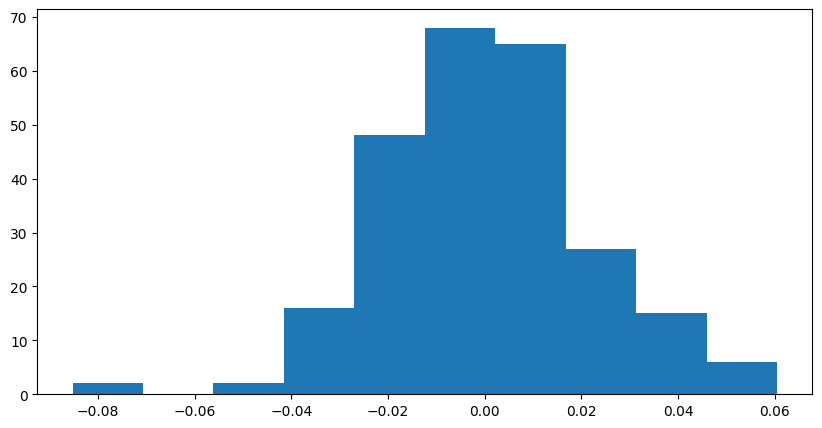

In [38]:
fig, ax = plt.subplots(figsize=(10,5))
plt.hist(new_df['Daily_change'])

In [39]:
expected_return = np.mean(new_df['Daily_change'])
volatility = np.var(new_df['Daily_change'])
print(expected_return, volatility)

0.0002504015839058085 0.0004720226859927409


In [40]:
expected_return/np.sqrt(volatility)

0.011525390149041314